🔍 サムネイル特徴量抽出中: 100%|███████████████████████████████████████████████████| 955/955 [2:06:56<00:00,  7.98s/it]


📉 RMSE（logスケール）: 0.4925
📈 RMSE（元スケール）: 184860.52


C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 24112 (\N{CJK UNIFIED IDEOGRAPH-5E30}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 23429 (\N{CJK UNIFIED IDEOGRAPH-5B85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 12376 (\N{HIRAGANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\317856245.py:152: UserWarning: Glyph 12427 (\N{HIRAGANA LET

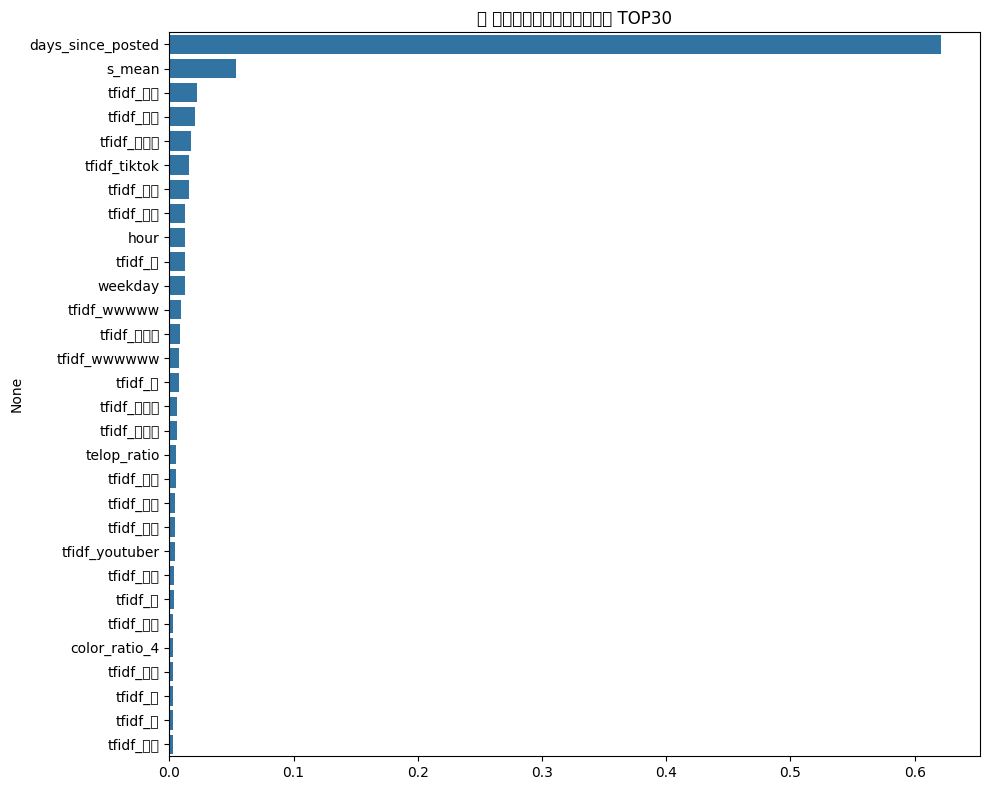

                                               title  \
0     過去一DMでリクエストが来た『2対1で相手をボコろうとするあきら』があまりにも神回だった件。   
1  【あみか100万人越えYouTuberとデート動画で物議/アマリザダイハツムーブ3台同時購入...   
2  【東海オンエアりょう恋人ができる/中町綾が手術を決意/なえなの大胆イメチェンで賛否/マナル隊...   
3                  HANA/ROSEをkemonoが完コピした動画がマジでやばい件。   
4  【スカイピース時事ネタに手を出すも大ゴケ&概要欄で宣戦布告？/がーどまんvsガミックス/ヒカ...   
5  【Rちゃん彼氏オーディションでできた彼氏とスピード破局/中町綾クレカを不正利用される/スカイ...   
6  【みそきん開店初日に口コミ大荒れ/エスポはんくんまさかの顔面スタンプ/DJ脇解散ライブ出演表...   
7  【みそきん実店舗オープンするも「高い」と話題に/既婚者ヒカル共演者とキスをし物議/リボーンコ...   
8  【こたつが活動休止していた件/トミー「YouTubeで稼げる時代は終わった」/えびじゃフジ悩...   
9                  コムドットやまとがXで「世論」に公開説教をかましている件について。   

                publishedAt  viewCount  predicted_viewCount  abs_error  
0 2025-08-28 12:01:54+00:00     164181               376618     212437  
1 2025-08-26 12:01:47+00:00     203592               384852     181260  
2 2025-08-23 12:01:57+00:00     236247               516147     279900  
3 2025-08-20 12:01:51+00:00     282421               407677     125256  
4 2025-08-17 12:01

In [1]:
# ✅ 初期化（ランダムサムネ特徴量を確実に埋める）
import pandas as pd
import numpy as np
from isodate import parse_duration
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from PIL import Image
import requests
from io import BytesIO
import cv2
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

# ✅ サムネイル特徴量定義
thumbnail_cols = [
    "brightness", "face_count", "telop_ratio",
    "r_mean", "g_mean", "b_mean",
    "h_mean", "s_mean", "v_mean"
] + [f"color_ratio_{i}" for i in range(5)]

# ✅ サムネイル画像から特徴量を抽出（MediaPipe）
def extract_all_thumbnail_features_mediapipe(url):
    try:
        response = requests.get(url, timeout=10)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        img_np = np.array(image)

        # 明度
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
        brightness = hsv[:, :, 2].mean()

        # 色平均
        r_mean = img_np[:, :, 0].mean()
        g_mean = img_np[:, :, 1].mean()
        b_mean = img_np[:, :, 2].mean()
        h_mean = hsv[:, :, 0].mean()
        s_mean = hsv[:, :, 1].mean()
        v_mean = hsv[:, :, 2].mean()

        # カラークラスタ比率（KMeansで5色）
        pixels = img_np.reshape(-1, 3)
        pixels = np.float32(pixels)
        _, labels, centers = cv2.kmeans(pixels, 5, None,
                                        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                        10, cv2.KMEANS_RANDOM_CENTERS)
        color_ratios = [np.sum(labels.flatten() == i) / len(labels) for i in range(5)]

        # telop_ratio（文字領域）仮：白領域比率
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
        telop_ratio = np.sum(thresh == 255) / thresh.size

        # 顔検出（MediaPipe）
        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            results = face_detection.process(cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
            face_count = len(results.detections) if results.detections else 0

        return [
            brightness, face_count, telop_ratio,
            r_mean, g_mean, b_mean, h_mean, s_mean, v_mean
        ] + color_ratios

    except:
        return [0] * len(thumbnail_cols)

# ✅ データ読み込みと前処理（Shorts除外）
df = pd.read_excel("youtube_dataset_20250829.xlsx")
df["title"] = df["title"].fillna("")
df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(-1).astype(int)
df["viewCount"] = pd.to_numeric(df["viewCount"], errors="coerce").fillna(0)
df["publishedAt"] = pd.to_datetime(df["publishedAt"], utc=True)
df["duration_seconds"] = df["duration"].apply(lambda x: parse_duration(x).total_seconds() if pd.notnull(x) else 0)
df = df[df["duration_seconds"] > 60].copy()

# 🔍 サムネイル特徴量抽出
if not set(thumbnail_cols).issubset(df.columns):
    if "thumbnail" not in df.columns:
        raise ValueError("⚠️ 'thumbnail'列がデータに存在しません")
    features = []
    for url in tqdm(df["thumbnail"], desc="🔍 サムネイル特徴量抽出中"):
        features.append(extract_all_thumbnail_features_mediapipe(url))
    thumbnail_df = pd.DataFrame(features, columns=thumbnail_cols)
    df = pd.concat([df.reset_index(drop=True), thumbnail_df], axis=1)

# 🕒 投稿時間特徴量
df["weekday"] = df["publishedAt"].dt.weekday
df["hour"] = df["publishedAt"].dt.hour
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
df["is_month_start"] = df["publishedAt"].dt.is_month_start.astype(int)
df["is_month_end"] = df["publishedAt"].dt.is_month_end.astype(int)
df["days_since_posted"] = (pd.Timestamp.now(tz="UTC") - df["publishedAt"]).dt.days

# ✅ 特徴量定義
feature_cols = [
    "categoryId", "weekday", "hour", "is_weekend", "is_month_start", "is_month_end", "days_since_posted"
] + thumbnail_cols

# ✅ TF-IDF（タイトル）ベクトル化
tokenizer = Tokenizer()
def tokenize_japanese(text):
    return [token.base_form for token in tokenizer.tokenize(text)
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞']]

vectorizer = TfidfVectorizer(tokenizer=tokenize_japanese, token_pattern=None, max_features=100)

# ✅ データ分割（6月以前を学習用に）
cutoff = pd.to_datetime("2025-07-01", utc=True)
df_train = df[df["publishedAt"] < cutoff].copy()
df_test = df[df["publishedAt"] >= cutoff].copy()

# TF-IDF変換
tfidf_train = vectorizer.fit_transform(df_train["title"])
tfidf_df_train = pd.DataFrame(tfidf_train.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df_train.index = df_train.index

tfidf_test = vectorizer.transform(df_test["title"])
tfidf_df_test = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_df_train.columns)
tfidf_df_test.index = df_test.index

# 特徴量統合
X_train = pd.concat([df_train[feature_cols].reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
y_train = np.log1p(df_train["viewCount"])

X_test = pd.concat([df_test[feature_cols].reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)
y_test = df_test["viewCount"]

# ✅ モデル学習と予測
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

log_preds = model.predict(X_test)
view_preds = np.expm1(log_preds).astype(int)

# ✅ 評価と可視化
rmse_log = mean_squared_error(np.log1p(y_test), log_preds) ** 0.5
rmse_raw = mean_squared_error(y_test, view_preds) ** 0.5
print(f"📉 RMSE（logスケール）: {rmse_log:.4f}")
print(f"📈 RMSE（元スケール）: {rmse_raw:.2f}")

# 特徴量の重要度
importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.tight_layout()
plt.show()

# 予測 vs 実測の誤差分析
df_result = df_test[["title", "publishedAt", "viewCount"]].copy()
df_result["predicted_viewCount"] = view_preds
df_result["abs_error"] = (df_result["predicted_viewCount"] - df_result["viewCount"]).abs()
df_result = df_result.sort_values("publishedAt", ascending=False).reset_index(drop=True)
print(df_result.head(10))


C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\2286212453.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)


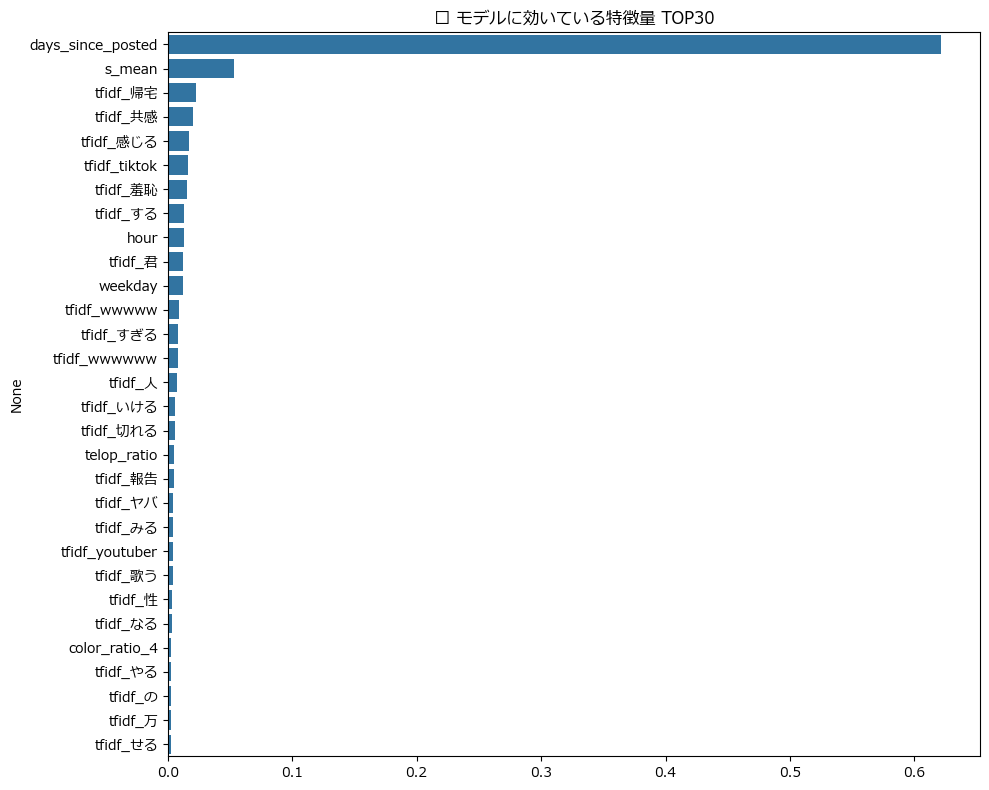

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 💬 日本語フォント設定（Windows: Meiryo、Mac: AppleGothic、Colab/Linux: IPAexGothicなどに切替可）
plt.rcParams['font.family'] = 'Meiryo'

# 特徴量の重要度グラフ
plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.tight_layout()
plt.show()

# 実測 vs 予測の誤差グラフなどもこのまま問題なく日本語表示されるようになります


C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\342686203.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)


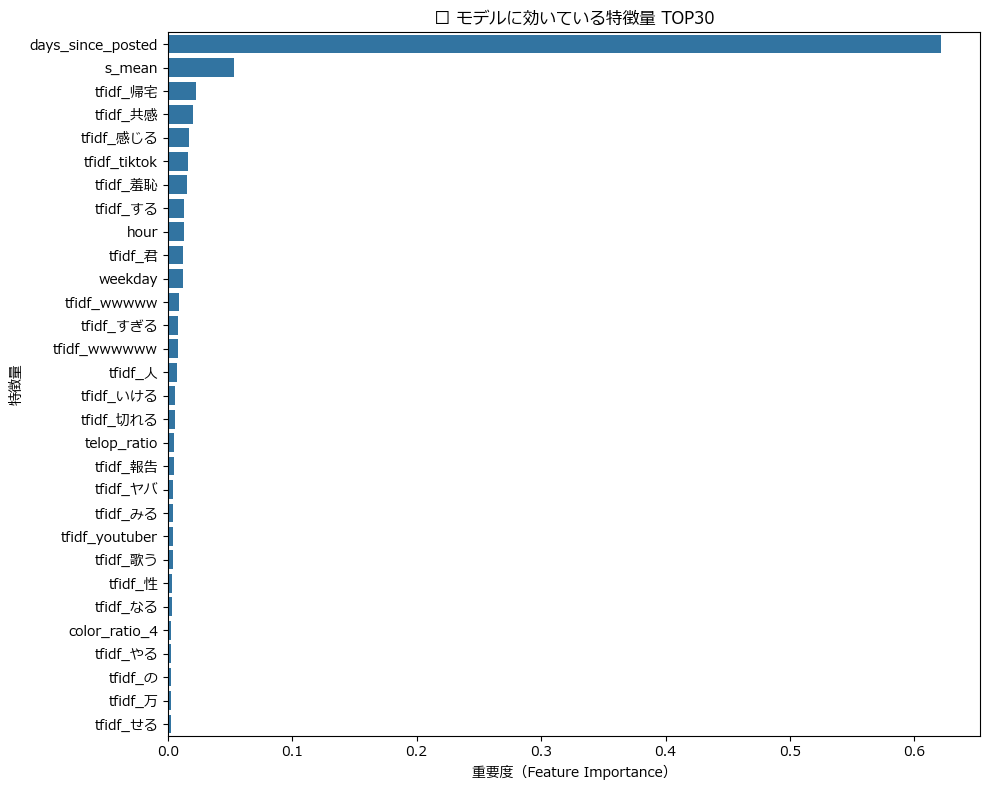

📋 特徴量の重要度（上位30）
                   importance
days_since_posted      0.6215
s_mean                 0.0536
tfidf_帰宅               0.0226
tfidf_共感               0.0206
tfidf_感じる              0.0173
tfidf_tiktok           0.0161
tfidf_羞恥               0.0156
tfidf_する               0.0128
hour                   0.0128
tfidf_君                0.0126
weekday                0.0123
tfidf_wwwww            0.0095
tfidf_すぎる              0.0086
tfidf_wwwwww           0.0080
tfidf_人                0.0076
tfidf_いける              0.0060
tfidf_切れる              0.0057
telop_ratio            0.0053
tfidf_報告               0.0050
tfidf_ヤバ               0.0045
tfidf_みる               0.0042
tfidf_youtuber         0.0042
tfidf_歌う               0.0041
tfidf_性                0.0037
tfidf_なる               0.0032
color_ratio_4          0.0030
tfidf_やる               0.0029
tfidf_の                0.0028
tfidf_万                0.0026
tfidf_せる               0.0026


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ✅ 日本語フォント（環境に応じて変更）
plt.rcParams['font.family'] = 'Meiryo'  # WindowsならMeiryo、MacならAppleGothicなど

# ✅ 特徴量の重要度算出
importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)

# ✅ グラフ描画
plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.xlabel("重要度（Feature Importance）")
plt.ylabel("特徴量")
plt.tight_layout()
plt.show()

# ✅ 数値で表示
print("📋 特徴量の重要度（上位30）")
print(top_imp.to_frame(name="importance").round(4))



In [4]:
# ✅ 投稿からの日数を再計算（UTC基準）
df_test["days_since_posted"] = (pd.Timestamp.now(tz="UTC") - df_test["publishedAt"]).dt.days

# ✅ 結果表示用データフレーム
df_result = df_test[["title", "publishedAt", "viewCount", "days_since_posted"]].copy()
df_result["predicted_viewCount"] = view_preds
df_result["abs_error"] = (df_result["predicted_viewCount"] - df_result["viewCount"]).abs()

# ✅ 日付の降順で並べ替え（新しい順）
df_result = df_result.sort_values("publishedAt", ascending=False).reset_index(drop=True)

# ✅ 表示
print(df_result.head(15))


                                                title  \
0      過去一DMでリクエストが来た『2対1で相手をボコろうとするあきら』があまりにも神回だった件。   
1   【あみか100万人越えYouTuberとデート動画で物議/アマリザダイハツムーブ3台同時購入...   
2   【東海オンエアりょう恋人ができる/中町綾が手術を決意/なえなの大胆イメチェンで賛否/マナル隊...   
3                   HANA/ROSEをkemonoが完コピした動画がマジでやばい件。   
4   【スカイピース時事ネタに手を出すも大ゴケ&概要欄で宣戦布告？/がーどまんvsガミックス/ヒカ...   
5   【Rちゃん彼氏オーディションでできた彼氏とスピード破局/中町綾クレカを不正利用される/スカイ...   
6   【みそきん開店初日に口コミ大荒れ/エスポはんくんまさかの顔面スタンプ/DJ脇解散ライブ出演表...   
7   【みそきん実店舗オープンするも「高い」と話題に/既婚者ヒカル共演者とキスをし物議/リボーンコ...   
8   【こたつが活動休止していた件/トミー「YouTubeで稼げる時代は終わった」/えびじゃフジ悩...   
9                   コムドットやまとがXで「世論」に公開説教をかましている件について。   
10                              喧嘩になった啓之輔のジムに乗り込んでみた。   
11               啓之輔をぶっ飛ばす為にキックボクシング練習してみた。※最後に重大告知有り   
12                  過去一「見てください！」とDMが来た動画が異次元すぎた件について。   
13  【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...   
14                        遂に決着がついてしまった件について。【真夏の喧嘩祭り】   

                 publishedAt  viewCount  days_since_posted  \
0  2025-08-28 12:01:54+00

📉 RMSE（logスケール）: 0.4925
📈 RMSE（元スケール）: 184860.52


C:\Users\Owner\AppData\Local\Temp\ipykernel_9956\4000065597.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\Owner\anaconda3\envs\faceenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)


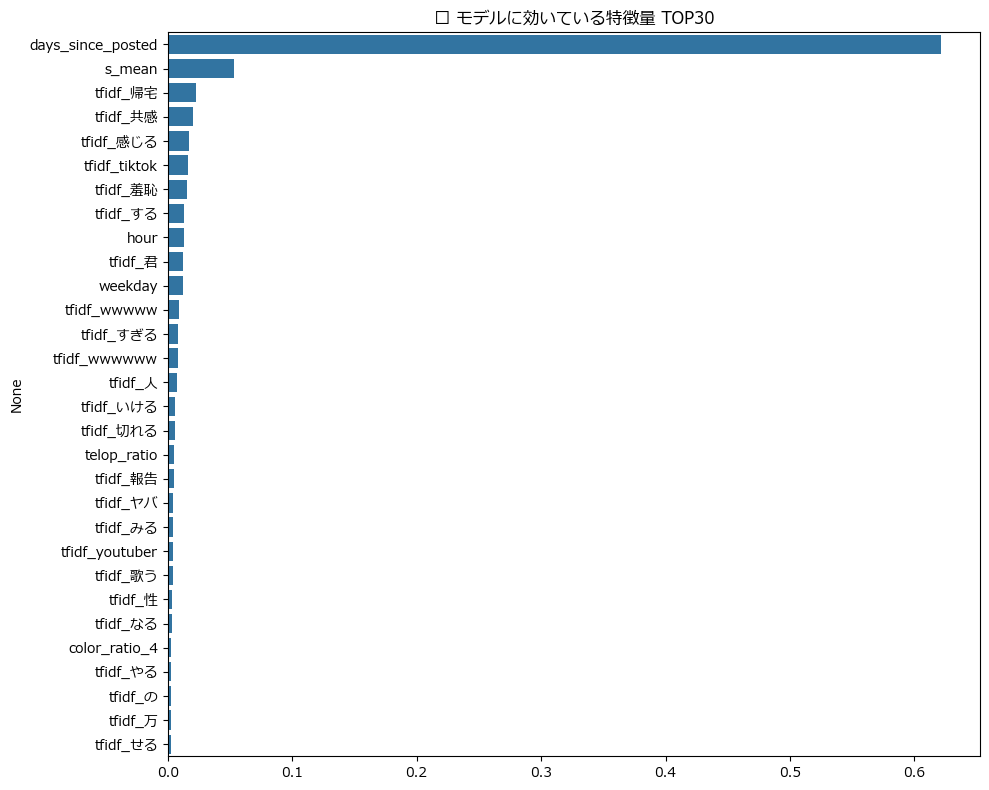

                                                title  \
0      過去一DMでリクエストが来た『2対1で相手をボコろうとするあきら』があまりにも神回だった件。   
1   【あみか100万人越えYouTuberとデート動画で物議/アマリザダイハツムーブ3台同時購入...   
2   【東海オンエアりょう恋人ができる/中町綾が手術を決意/なえなの大胆イメチェンで賛否/マナル隊...   
3                   HANA/ROSEをkemonoが完コピした動画がマジでやばい件。   
4   【スカイピース時事ネタに手を出すも大ゴケ&概要欄で宣戦布告？/がーどまんvsガミックス/ヒカ...   
5   【Rちゃん彼氏オーディションでできた彼氏とスピード破局/中町綾クレカを不正利用される/スカイ...   
6   【みそきん開店初日に口コミ大荒れ/エスポはんくんまさかの顔面スタンプ/DJ脇解散ライブ出演表...   
7   【みそきん実店舗オープンするも「高い」と話題に/既婚者ヒカル共演者とキスをし物議/リボーンコ...   
8   【こたつが活動休止していた件/トミー「YouTubeで稼げる時代は終わった」/えびじゃフジ悩...   
9                   コムドットやまとがXで「世論」に公開説教をかましている件について。   
10                              喧嘩になった啓之輔のジムに乗り込んでみた。   
11               啓之輔をぶっ飛ばす為にキックボクシング練習してみた。※最後に重大告知有り   
12                  過去一「見てください！」とDMが来た動画が異次元すぎた件について。   
13  【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...   
14                        遂に決着がついてしまった件について。【真夏の喧嘩祭り】   

                 publishedAt  viewCount  days_since_posted  \
0  2025-08-28 12:01:54+00

In [5]:
# ✅ 初期化（ライブラリ読み込み・特徴定義など省略済み）

# ✅ データ分割（6月以前を学習用、7〜8月を予測用に）
cutoff_train = pd.to_datetime("2025-07-01", utc=True)
cutoff_test = pd.to_datetime("2025-09-01", utc=True)

df_train = df[df["publishedAt"] < cutoff_train].copy()
df_test = df[(df["publishedAt"] >= cutoff_train) & (df["publishedAt"] < cutoff_test)].copy()

# ✅ TF-IDF変換
tfidf_train = vectorizer.fit_transform(df_train["title"])
tfidf_df_train = pd.DataFrame(tfidf_train.toarray(), columns=[f"tfidf_{w}" for w in vectorizer.get_feature_names_out()])
tfidf_df_train.index = df_train.index

tfidf_test = vectorizer.transform(df_test["title"])
tfidf_df_test = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_df_train.columns)
tfidf_df_test.index = df_test.index

# ✅ 特徴量統合
X_train = pd.concat([df_train[feature_cols].reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
y_train = np.log1p(df_train["viewCount"])

X_test = pd.concat([df_test[feature_cols].reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)
y_test = df_test["viewCount"]

# ✅ モデル学習と予測
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

log_preds = model.predict(X_test)
view_preds = np.expm1(log_preds).astype(int)

# ✅ 評価と可視化
rmse_log = mean_squared_error(np.log1p(y_test), log_preds) ** 0.5
rmse_raw = mean_squared_error(y_test, view_preds) ** 0.5
print(f"📉 RMSE（logスケール）: {rmse_log:.4f}")
print(f"📈 RMSE（元スケール）: {rmse_raw:.2f}")

# ✅ 特徴量の重要度 可視化
importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_imp = importance.sort_values(ascending=False).head(30)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("📊 モデルに効いている特徴量 TOP30")
plt.tight_layout()
plt.show()

# ✅ 予測 vs 実測（days_since_posted 付き）
df_result = df_test[["title", "publishedAt", "viewCount", "days_since_posted"]].copy()
df_result["predicted_viewCount"] = view_preds
df_result["abs_error"] = (df_result["predicted_viewCount"] - df_result["viewCount"]).abs()
df_result = df_result.sort_values("publishedAt", ascending=False).reset_index(drop=True)

# ✅ 表示
print(df_result.head(15))



In [7]:
print(df_result)

                                                title  \
0      過去一DMでリクエストが来た『2対1で相手をボコろうとするあきら』があまりにも神回だった件。   
1   【あみか100万人越えYouTuberとデート動画で物議/アマリザダイハツムーブ3台同時購入...   
2   【東海オンエアりょう恋人ができる/中町綾が手術を決意/なえなの大胆イメチェンで賛否/マナル隊...   
3                   HANA/ROSEをkemonoが完コピした動画がマジでやばい件。   
4   【スカイピース時事ネタに手を出すも大ゴケ&概要欄で宣戦布告？/がーどまんvsガミックス/ヒカ...   
5   【Rちゃん彼氏オーディションでできた彼氏とスピード破局/中町綾クレカを不正利用される/スカイ...   
6   【みそきん開店初日に口コミ大荒れ/エスポはんくんまさかの顔面スタンプ/DJ脇解散ライブ出演表...   
7   【みそきん実店舗オープンするも「高い」と話題に/既婚者ヒカル共演者とキスをし物議/リボーンコ...   
8   【こたつが活動休止していた件/トミー「YouTubeで稼げる時代は終わった」/えびじゃフジ悩...   
9                   コムドットやまとがXで「世論」に公開説教をかましている件について。   
10                              喧嘩になった啓之輔のジムに乗り込んでみた。   
11               啓之輔をぶっ飛ばす為にキックボクシング練習してみた。※最後に重大告知有り   
12                  過去一「見てください！」とDMが来た動画が異次元すぎた件について。   
13  【清純売りYouTuberいけちゃんの不倫発覚/DJふぉい年末解散ライブへの出演を発表/テオ...   
14                        遂に決着がついてしまった件について。【真夏の喧嘩祭り】   
15                           コムドットの漫才が酷すぎると話題なので見てみた。   
16                       YouTub

In [8]:
# ✅ カラム順を指定して並べ替え
df_result = df_result[[
    "days_since_posted", "viewCount", "predicted_viewCount", "abs_error", "publishedAt", "title"
]]

# ✅ 表示
print(df_result.head(15))


    days_since_posted  viewCount  predicted_viewCount  abs_error  \
0                   0     164181               376618     212437   
1                   2     203592               384852     181260   
2                   5     236247               516147     279900   
3                   8     282421               407677     125256   
4                  11     383307               420293      36986   
5                  14     325898               417954      92056   
6                  15     283085               460534     177449   
7                  18     314359               430094     115735   
8                  20     283815               403006     119191   
9                  23     442249               416909      25340   
10                 25     830944               374561     456383   
11                 26     289165               457870     168705   
12                 27     520747               361689     159058   
13                 30     453653               4